In [1]:
import pandas as pd
import numpy as np 
import csv
import matplotlib.pyplot as plt
import math
from pandas_datareader import data
import scipy.optimize
from scipy import stats
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import griddata

In [2]:
#read the list of tickers from file

tickers_file = 'TechTickers.csv'
tickers = [];
f = open(tickers_file,"r",encoding='utf-8-sig')
for line in csv.reader(f):
    tickers.append(str(line[0]))
f.close

#download data from yahoo between the starting and ending dates

start_date = '2009-01-01'
end_date = '2019-12-31'
stock_data = data.get_data_yahoo(tickers, start_date, end_date)
adjClosing = stock_data['Adj Close']
returns = adjClosing.pct_change()

In [ ]:
#1  In this question, you construct dynamic utility-optimizing trading strategies. 
# (Do not forget that the riskless return is a part of the universe of available assets.) 
# Use the power utility with γ = 1/2, the trading time horizon T = 100 (measured in days), 
# and the calibration window size N = 250.

# 1a Construct the optimal strategy for each asset with the riskless one. 
# Output their PnL process, annualized mean, variance and Sharpe ratio

 Solving Merton's problem for our utility function U(x)=((X0*x)^gamma)/gamma:
 Let a = alpha(risky), m = mean, s = standard Dev, e = error, r = riskless return rate
 In the case where gamma < 1 (here gamma = 1/2), we can solve for a* explicitly:

 Our Utility function is U(x)=2(X0*x)^0.5
 and the DPP function is in the form V(t,x)=2(x^0.5)(c(t))
 where c(t)=max(a)EV[X0(max(a)E(2(1+a(m+e)+(1-a)r)^0.5)]
 solving for the a that maximizes the above function is equivalent to solving..
  E(2(1+a(m+e)+(1-a)r)^0.5) = (1+a(m+s)+(1-a)r)^0.5 + (1+a(m-s)+(1-a)r)^0.5
                            = (1+r+a(m-r+s))^0.5 + (1+r+a(m-r-s))^0.5
 Take derivative with respect to a, set it = 0
                          0 = (1/2)(m-r+s)(1+r+a(m-r+s))^-0.5 + (1/2)(m-r-s)(1+r+a(m-r-s))^-0.5
                         a* = 2(r+1)(r-m)/((m-r)^2-s^2)
 we can now use this formula to calculate a* explicitly for our window samples

In [3]:
# define the function for calculating the alpha
def alpha_star(mean, sd, r):
    # r = daily riskless rate of returns
    a = 2*(r+1)*(r-mean)/(((mean-r)**2)-sd**2)
    return a

In [202]:
# We now backtest by using 250 sized windows to calibrate a* for calculating
# the returns of the subseding 100 days

# first we check how many sets of 100 days are we going to compute (excluding the first window)
#print(len(returns)-1-250)

# there are 2517 days, so we will ignore the last 17 days and backtest for 25 iterations
newReturns = []
risklessRet = 0.01
dailyR = risklessRet/250
start = 1
N = 250
T = 100
PnLs = []
cumuRet = []
alphas = []

for iter in range(25):
    sample_mean = returns[['AAPL']][(start+iter*T):(start+N+iter*T)].values.mean()
    sample_sd = returns[['AAPL']][(start+iter*T):(start+N+iter*T)].values.std()

    alphas.append(alpha_star(sample_mean, sample_sd, dailyR))
    newReturns = np.append(newReturns, returns[['AAPL']][(start+N+iter*T):(start+N+T+iter*T)].values * alphas[iter] + (1-alphas[iter]) * dailyR)
    windowPnL = np.prod(1 + returns[['AAPL']][(start+N+iter*T):(start+N+T+iter*T)].values * alphas[iter] + (1-alphas[iter]) * dailyR)
    PnLs.append(windowPnL)
    if iter == 0:
        cumuRet.append(windowPnL)
    else:
        cumuRet.append(cumuRet[iter-1] * windowPnL)
    

In [203]:
annualized_ret = np.mean(newReturns)*250
annualized_var = np.var(newReturns, ddof=1)*250
Sharpe_ratio = (annualized_ret - risklessRet)/np.sqrt(annualized_var)
print(annualized_ret, annualized_var, Sharpe_ratio)

np.savetxt('a_PnL.csv', np.array(cumuRet))
np.savetxt('a_strat.csv', np.array([annualized_ret, annualized_var, Sharpe_ratio]))

2.0897370610496417 13.807528892472101 0.5596937415786019


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

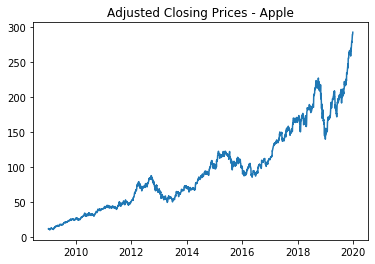

In [116]:
plt.plot(stock_data['Adj Close'][['AAPL']])
plt.title('Adjusted Closing Prices - Apple')
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

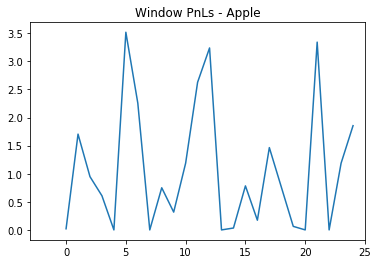

In [179]:
plt.plot(PnLs)
plt.title('Window PnLs - Apple')
plt.xlim(-3,25)
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

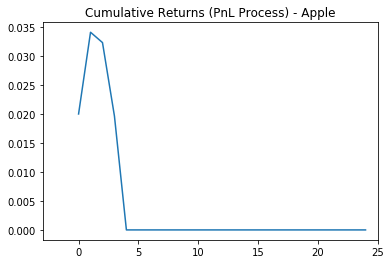

In [180]:
plt.plot(cumuRet)
plt.title('Cumulative Returns (PnL Process) - Apple')
plt.xlim(-3,25)
plt.plot

In [88]:
#1b Construct the optimal strategy for each asset with the riskless one and volume-exponentially weighted avg price. 
# Output their PnL process, annualized mean, variance and Sharpe ratio

downScale = 10**4 #downsize volume units to calculable range

# Volume-exp weighted average price function for the calibration window
def VEWAP_reg(ticker, winStart, winSize):
    vol = np.array(stock_data['Volume'][[ticker]])/downScale
    ret = np.array(returns[[ticker]][winStart:winStart+winSize]).T[0].tolist()
    vewaps = []
    for t in range(winSize-1):
        Ft = 0
        for j in range(t+1):
            Ft += vol[winStart+t-j] * ret[t-j]/(np.exp(j))

        vewaps.append(Ft[0])
    #regress Returns of day t+1 on to factors day t
    slope, intercept, r, p, se = stats.linregress(vewaps, ret[1:]) 
    
    #calc mean and sd of volumes
    vol_mean = np.mean(vol[winStart:winStart+winSize-1])
    vol_sd = np.std(vol[winStart:winStart+winSize-1], ddof=1)
    
    #calc mean and sd of factors
    f_mean = np.mean(vewaps)
    f_sd = np.std(vewaps, ddof=1)
    #print(f_mean, f_sd)
    f_arr = np.linspace(f_mean-3*f_sd, f_mean+3*f_sd, num=100)

    #calc standard dev of returns
    ret_sd = np.std(ret)
    
    return intercept, slope, vol_mean, vol_sd, ret_sd, f_arr

In [311]:
# define value function

def V(alpha,t,f):
    if t == 99:
        # Here I had to scale the initial state by 100 to allow big enough changes between value function updates;
        # removing the '100x' would still allow the DPP to finish from t=99...0, but there would be occasional 
        #  sequences of 0.5 in the alphas which would not be usable in the interpolate function
        #  Scaling the initial state does NOT affect the alphas achieved.
        return 100*(((1+alpha[0]*(a+c*f+ret_sd)+alpha[1]*dailyR)**gamma)+((1+alpha[0]*(a+c*f-ret_sd)+alpha[1]*dailyR)**gamma)) 
    else:    
        return (((1+alpha[0]*(a+c*f+ret_sd)+alpha[1]*dailyR)**gamma)/4*(Vtplus1(np.exp(-1)*f+(vol_mean+vol_sd)*(a+c*f+ret_sd))
                                                                    +Vtplus1(np.exp(-1)*f+(vol_mean-vol_sd)*(a+c*f+ret_sd)))
                +((1+alpha[0]*(a+c*f-ret_sd)+alpha[1]*dailyR)**gamma)/4*(Vtplus1(np.exp(-1)*f+(vol_mean+vol_sd)*(a+c*f-ret_sd))
                                                                   +Vtplus1(np.exp(-1)*f+(vol_mean-vol_sd)*(a+c*-ret_sd))))

def maxV(alpha,t,f):
    return -V(alpha,t,f)

In [352]:
# DPP
# This process will only be repeated for one asset (AAPL), the actual process can be looped by using the tickers list

ticker = 'AAPL'
newReturns = []
PnLs = []
cumuRet = []

T = 100
gamma = 0.5
alpha_init = [0.50, 0.50]
cons=({'type': 'eq', 'fun': lambda w:  np.sum(w)-1.0})
vol = np.array(stock_data['Volume'][[ticker]])/downScale
ret = np.array(returns[[ticker]]).T[0].tolist()

#the calibration window is supposed to move for 25 times
for iter in range(3):
    print('..processing window #', iter)
    a,c,vol_mean,vol_sd,ret_sd,f_arr = VEWAP_reg(ticker,start+iter*T,N)
    Vtplus1 = 1 #declare V(t+1,.) function; this will be redefined by interpolations later

    alpha_stars = []
    realizedFs = []

    for t in range(99,-1,-1):
        #print(t)
        v_vals = []
        best_alphas = []
        for f in f_arr:
            weights = scipy.optimize.minimize(maxV, alpha_init, (t, f), method='SLSQP', constraints=cons)
            v_vals.append(-weights.fun)
            best_alphas.append(weights.x[0])

        #update the V(t+1,.) function for the next t
        Vtplus1 = scipy.interpolate.UnivariateSpline(f_arr, v_vals)

        #calculate the realized f value and predict alphaStar(t,f)
        alphaStar = scipy.interpolate.UnivariateSpline(f_arr, best_alphas)
        
        realizedF = 0
        #for backtesting the 100 days, we actually compute the factors since day t=-1 or else day t=0 will have no factors
        for i in range(t,-1,-1):
            realizedF += vol[start+iter*T+N+i] * ret[start+iter*T+N+i]/np.exp(t-i)
        #realizedFs.append(realizedF[0])
        alpha_stars.append(alphaStar(realizedF)[0])
    
    #the alpha stars were collected in reverse order
    alpha_stars = alpha_stars[::-1]
    
    for day in range(T):
        newRet = ret[start+N+iter*T+day] * alpha_stars[day] + (1-alpha_stars[day]) * dailyR
        newReturns.append(newRet)    
        dailyPnL = 1 + newRet
        PnLs.append(dailyPnL)
    

..processing window # 0
..processing window # 1
..processing window # 2


In [353]:
for day in range(len(PnLs)):
    if day == 0:
        cumuRet.append(PnLs[0])
    else:
        cumuRet.append(cumuRet[day-1] * PnLs[day])

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

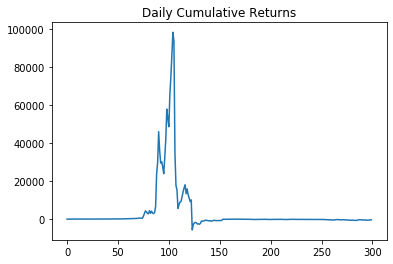

In [354]:
plt.plot(cumuRet[:300])
plt.title('Daily Cumulative Returns')
plt.plot

In [355]:
annualized_ret = np.mean(newReturns)*250
annualized_var = np.var(newReturns, ddof=1)*250
Sharpe_ratio = (annualized_ret - risklessRet)/np.sqrt(annualized_var)
print(annualized_ret, annualized_var, Sharpe_ratio)

np.savetxt('b_PnL.csv', np.array(cumuRet))
np.savetxt('b_strat.csv', np.array([annualized_ret, annualized_var, Sharpe_ratio]))

13.50368238683736 26.537542562765037 2.6193897979880996


In [356]:
#1c Repeat part a) but with a proportional transaction cost
# First we define our objective function (value function)

def V(alpha,t,a):
    if t == T-1:
        return -100*(((1+alpha[0]*(m+sd)+alpha[1]*dailyR-lamb*np.abs(alpha[0]-a))**gamma)/2+((1+alpha[0]*(m-sd)+alpha[1]*dailyR-lamb*np.abs(alpha[0]-a))**gamma)/2) 
    else:    
        return -(((1+alpha[0]*(m+sd)+alpha[1]*dailyR-lamb*np.abs(alpha[0]-a))**gamma)/2*Vtplus1(alpha[0]*(1+m+sd)/(1+alpha[0]*(m+sd)+alpha[1]*dailyR))
                 +((1+alpha[0]*(m-sd)+alpha[1]*dailyR-lamb*np.abs(alpha[0]-a))**gamma)/2*Vtplus1(alpha[0]*(1+m-sd)/(1+alpha[0]*(m-sd)+alpha[1]*dailyR)))

In [357]:
# DPP
# This process will only be repeated for one asset (AAPL), the actual process can be looped by using the tickers list

ticker = 'AAPL'
newReturns = []
PnLs = []
cumuRet = []

T = 15
gamma = 0.5
lamb = 0.01
alpha_init = [0.50, 0.50]
weights_b4_balance = np.linspace(-2,2, num=100)
cons=({'type': 'eq', 'fun': lambda w:  np.sum(w)-1.0})
vol = np.array(stock_data['Volume'][[ticker]])/downScale
ret = np.array(returns[[ticker]]).T[0].tolist()

#the calibration window is supposed to move for 25 times
for iter in range(1):
    print('..processing window #', iter)
    m = np.mean(returns[[ticker]][(start+iter*T):(start+N+iter*T)])
    sd = np.std(returns[[ticker]][(start+iter*T):(start+N+iter*T)], ddof=1)
    Vtplus1 = 1 #declare V(t+1,.) function; this will be redefined by interpolations later
    alpha_func = []

    for t in range(T-1,-1,-1):
        #print(t)
        v_vals = []
        best_alphas = []
        for a in weights_b4_balance:
            weights = scipy.optimize.minimize(V, alpha_init, (t, a), method='SLSQP', constraints=cons)
            v_vals.append(-weights.fun)
            best_alphas.append(weights.x[0])

        #update the V(t+1,.) function for the next t
        Vtplus1 = scipy.interpolate.UnivariateSpline(weights_b4_balance, v_vals)

        #predict alphaStar(t,a) from previous alpha
        alphaStar = scipy.interpolate.UnivariateSpline(weights_b4_balance, best_alphas)
        #store function for a(t,.)
        alpha_func.append(alphaStar)
        
    #for backtesting the 100 days, we move forward, predicting the next best alpha from the last, starting at t=-1
    #the alpha star functions were collected in reverse order
    alpha_func = alpha_func[::-1]
    alpha_stars = []
    for f in range(len(alpha_func)):
        if f == 0:
            alpha_stars.append(alpha_func[f](0))
        else:
            alpha_stars.append(alpha_func[f](alpha_stars[f-1]))
    

..processing window # 0
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [366]:
# calculate PnL process for 15 days

newReturns = []
cumuRet = []
for day in range(T):
    if day==0:
        newRet = np.array(returns[[ticker]])[day+251] * alpha_stars[day] + (1-alpha_stars[day]) * dailyR - lamb*np.absolute(alpha_stars[day])
    else:
        newRet = np.array(returns[[ticker]])[day+251] * alpha_stars[day] + (1-alpha_stars[day]) * dailyR - lamb*np.absolute(alpha_stars[day]-alpha_stars[day-1])
    pnl = 1 + newRet
    newReturns.append(newRet)
    if day==0:
        cumuRet.append(pnl)
    else:
        cumuRet.append(cumuRet[day-1] * pnl)

In [367]:
annualized_ret = np.mean(newReturns)*250
annualized_var = np.var(newReturns, ddof=1)*250
Sharpe_ratio = (annualized_ret - risklessRet)/np.sqrt(annualized_var)
print(annualized_ret, annualized_var, Sharpe_ratio)

np.savetxt('c_PnL.csv', np.array(cumuRet))
np.savetxt('c_strat.csv', np.array([annualized_ret, annualized_var, Sharpe_ratio]))

-55.80796028605976 24.71979211131975 -11.226685464718882


<function matplotlib.pyplot.show(*args, **kw)>

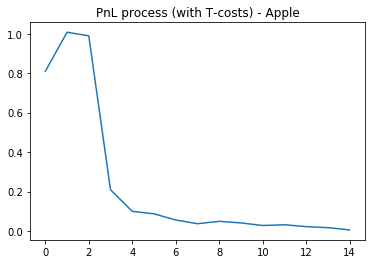

In [368]:
plt.plot(cumuRet)
plt.title('PnL process (with T-costs) - Apple')
plt.show